# PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys

sys.path += ['..', '../..']
from modules.symmetric_matrix import logm
from modules.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

## load images

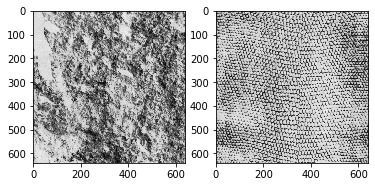

In [3]:
import os
import random

patch_size = (32, 32)
extraction_step = patch_size
n_components = 3
eps = 1e-16

path = '../../data/brodatz'
imgs = [cv2.imread(os.path.join(path, f'D{i}.png'), False) for i in range(2, 12)]

patches = [extract_patches_2d(img, patch_size, extraction_step).astype(np.float) / 255. for img in imgs]
length, half_length = len(patches[0]), len(patches[0]) // 2
shuffled_indices = list(range(length))
random.shuffle(shuffled_indices)

train_patches = np.vstack([patch[shuffled_indices[:half_length]] for patch in patches])
test_patches = np.vstack([patch[shuffled_indices[half_length:]] for patch in patches])

plt.subplot(1,2,1)
plt.imshow(imgs[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs[1], cmap='gray')
plt.show()

特徴量

In [4]:
# %%time
from typing import List

kernels = [
    np.array([[0,0,0],[-1,0,1],[0,0,0]]),
    np.array([[0,-1,0],[0,0,0],[0,1,0]]),
    np.array([[0,0,0],[-1,2,-1],[0,0,0]]),
    np.array([[0,-1,0],[0,2,0],[0,-1,0]])
]

def extract_feature(patches: np.ndarray, kernels: list, eps: float=1e-8):
    n_patches, p_h, p_w = patches.shape[:3]
    res = np.empty((n_patches, p_h * p_w, 1 + len(kernels)))

    res[:,:,0] = patches.reshape(-1, p_h * p_w)
    for i, kernel in enumerate(kernels):
        res[:,:,i+1] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel)) for p in patches]).reshape(-1, p_h * p_w)
    return np.array([np.cov(x, rowvar=False) + np.eye(1 + len(kernels)) * eps for x in res])

# def extract_feature(
#     img: np.ndarray, gimg: np.ndarray, kernels: list, 
#     patch_size: tuple = (32, 32), extraction_step: tuple = (32, 32), eps: float=1e-8
# ): 
#     ret = [im for im in img.transpose(2, 0, 1)] if len(img.shape) == 3 else [img]
#     for kernel in kernels:
#         ret.append(np.abs(cv2.filter2D(gimg, cv2.CV_64F, kernel)))
#     patches = extract_patches_2d(np.array(ret).transpose(1, 2, 0), patch_size, extraction_step)
#     p_l, p_h, p_w, p_c = patches.shape
#     patches = patches.reshape(p_l, p_h * p_w, p_c)
#     return np.array([np.cov(x, rowvar=False) + np.eye(p_c) * eps for x in patches])

train_feature = extract_feature(train_patches, kernels)
test_feature = extract_feature(test_patches, kernels)
# feature = extract_feature(img_hsv, img_hsv[:, :, 2], kernels, patch_size, extraction_step)
# feature = extract_feature(img.astype(np.float) / 255., img_hsv[:, :, 2], kernels, patch_size, extraction_step)

## kernel

$$k_p(x,y) = \exp\left(-\gamma \|\log_px - \log_py\|_p^2\right)$$

### Symmetrix Positive Definite Matrix

$$k_I(X,Y) = \exp\left(-\gamma \|\log_IX - \log_IY\|_I^2\right)$$

In [11]:
from joblib import Parallel, delayed
from itertools import combinations, product
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA

In [6]:
num_train = len(train_feature)
%time log_train = Parallel(n_jobs=-1, backend='multiprocessing')([delayed(logm)(x) for x in train_feature])
%time diff_train = Parallel(n_jobs=-1, backend='multiprocessing')([delayed(np.vdot)(x - y, x - y) for x, y in combinations(log_train, 2)])

num_test = len(test_feature)
%time log_test = Parallel(n_jobs=-1, backend='multiprocessing')([delayed(logm)(x) for x in test_feature])
%time diff_test = Parallel(n_jobs=-1, backend='multiprocessing')([delayed(np.vdot)(x - y, x - y) for x, y in product(log_test, log_train)])

CPU times: user 170 ms, sys: 97 ms, total: 267 ms
Wall time: 526 ms
CPU times: user 1min 1s, sys: 4.01 s, total: 1min 5s
Wall time: 1min 6s
CPU times: user 145 ms, sys: 33.5 ms, total: 179 ms
Wall time: 410 ms
CPU times: user 2min 15s, sys: 13.3 s, total: 2min 28s
Wall time: 2min 40s


In [17]:
gamma = 0.1

x_train = np.exp(-np.array(diff_train) * gamma)
X_train = np.identity(num_train)
X_train[np.triu_indices(num_train, 1)] = x_train
X_train.T[np.triu_indices(num_train, 1)] = x_train

x_test = np.exp(-np.array(diff_test) * gamma)
X_test = x_test.reshape(num_test, num_train)

### PCA

In [18]:
%%time
pca = KernelPCA(n_components=10, kernel='precomputed', random_state=0)
decomposed = pca.fit_transform(X_train)

CPU times: user 967 ms, sys: 47.4 ms, total: 1.01 s
Wall time: 571 ms


In [19]:
%%time
y = np.hstack([[i] * half_length for i in range(len(imgs))]).astype(np.float)
svm = SVC(C=1.0, kernel='linear', random_state=0)
svm.fit(decomposed, y)

CPU times: user 46 ms, sys: 5.69 ms, total: 51.7 ms
Wall time: 28.9 ms


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

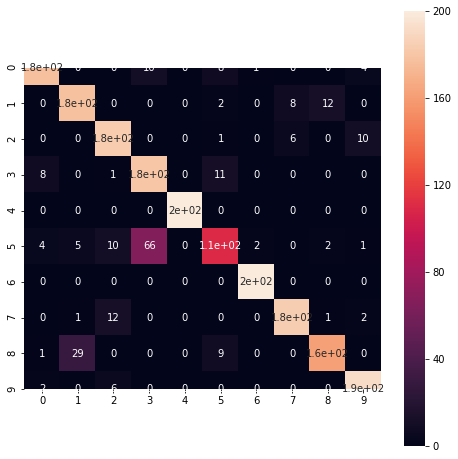

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

pred = svm.predict(pca.transform(X_test))
confusion_ = confusion_matrix(y, pred)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_, square=True, annot=True)
plt.show()